In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple, List, Type, Dict, Any


In [ ]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:

class Perceptron(torch.nn.Module):
    
    def __init__(self, 
                 input_resolution: Tuple[int, int] = (28, 28),
                 input_channels: int = 1, 
                 hidden_layer_features: List[int] = [256, 256, 256],
                 activation: Type[torch.nn.Module] = torch.nn.ReLU,
                 num_classes: int = 10):

        super().__init__()
        self.input_resolution = input_resolution
        self.input_channels = input_channels
        self.hidden_layer_features = hidden_layer_features
        self.activation = activation
        self.num_classes = num_classes
        
        self.layer1 = torch.nn.Linear(self.input_resolution[0] * self.input_resolution[1], 128)
        self.layer2 = torch.nn.Linear(128, self.num_classes)
        
    def forward(self, x):
        x = x.to(device)
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        
        softmax = torch.nn.functional.softmax(x, dim = 1)
        x = softmax(x)
        x = x.to(device)
        return x

In [ ]:
model = Perceptron()
print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

Perceptron(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=10, bias=True)
)
Total number of trainable parameters 101770


In [ ]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees = 20),
    torchvision.transforms.RandomCrop(size = (28, 28)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
    
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                           train=True, 
                                           download=True,
                                           transform=train_transforms)

val_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                         train=False, 
                                         download=True, 
                                         transform=val_transforms)

In [ ]:
data = list()
for i in range(len(train_dataset)):
    data.append(train_dataset[i][0].numpy())
data = np.array(data)
print('std:', data.std())
print('mean:', data.mean())

std: 1.0000196
mean: -0.00016416698


In [ ]:
del data

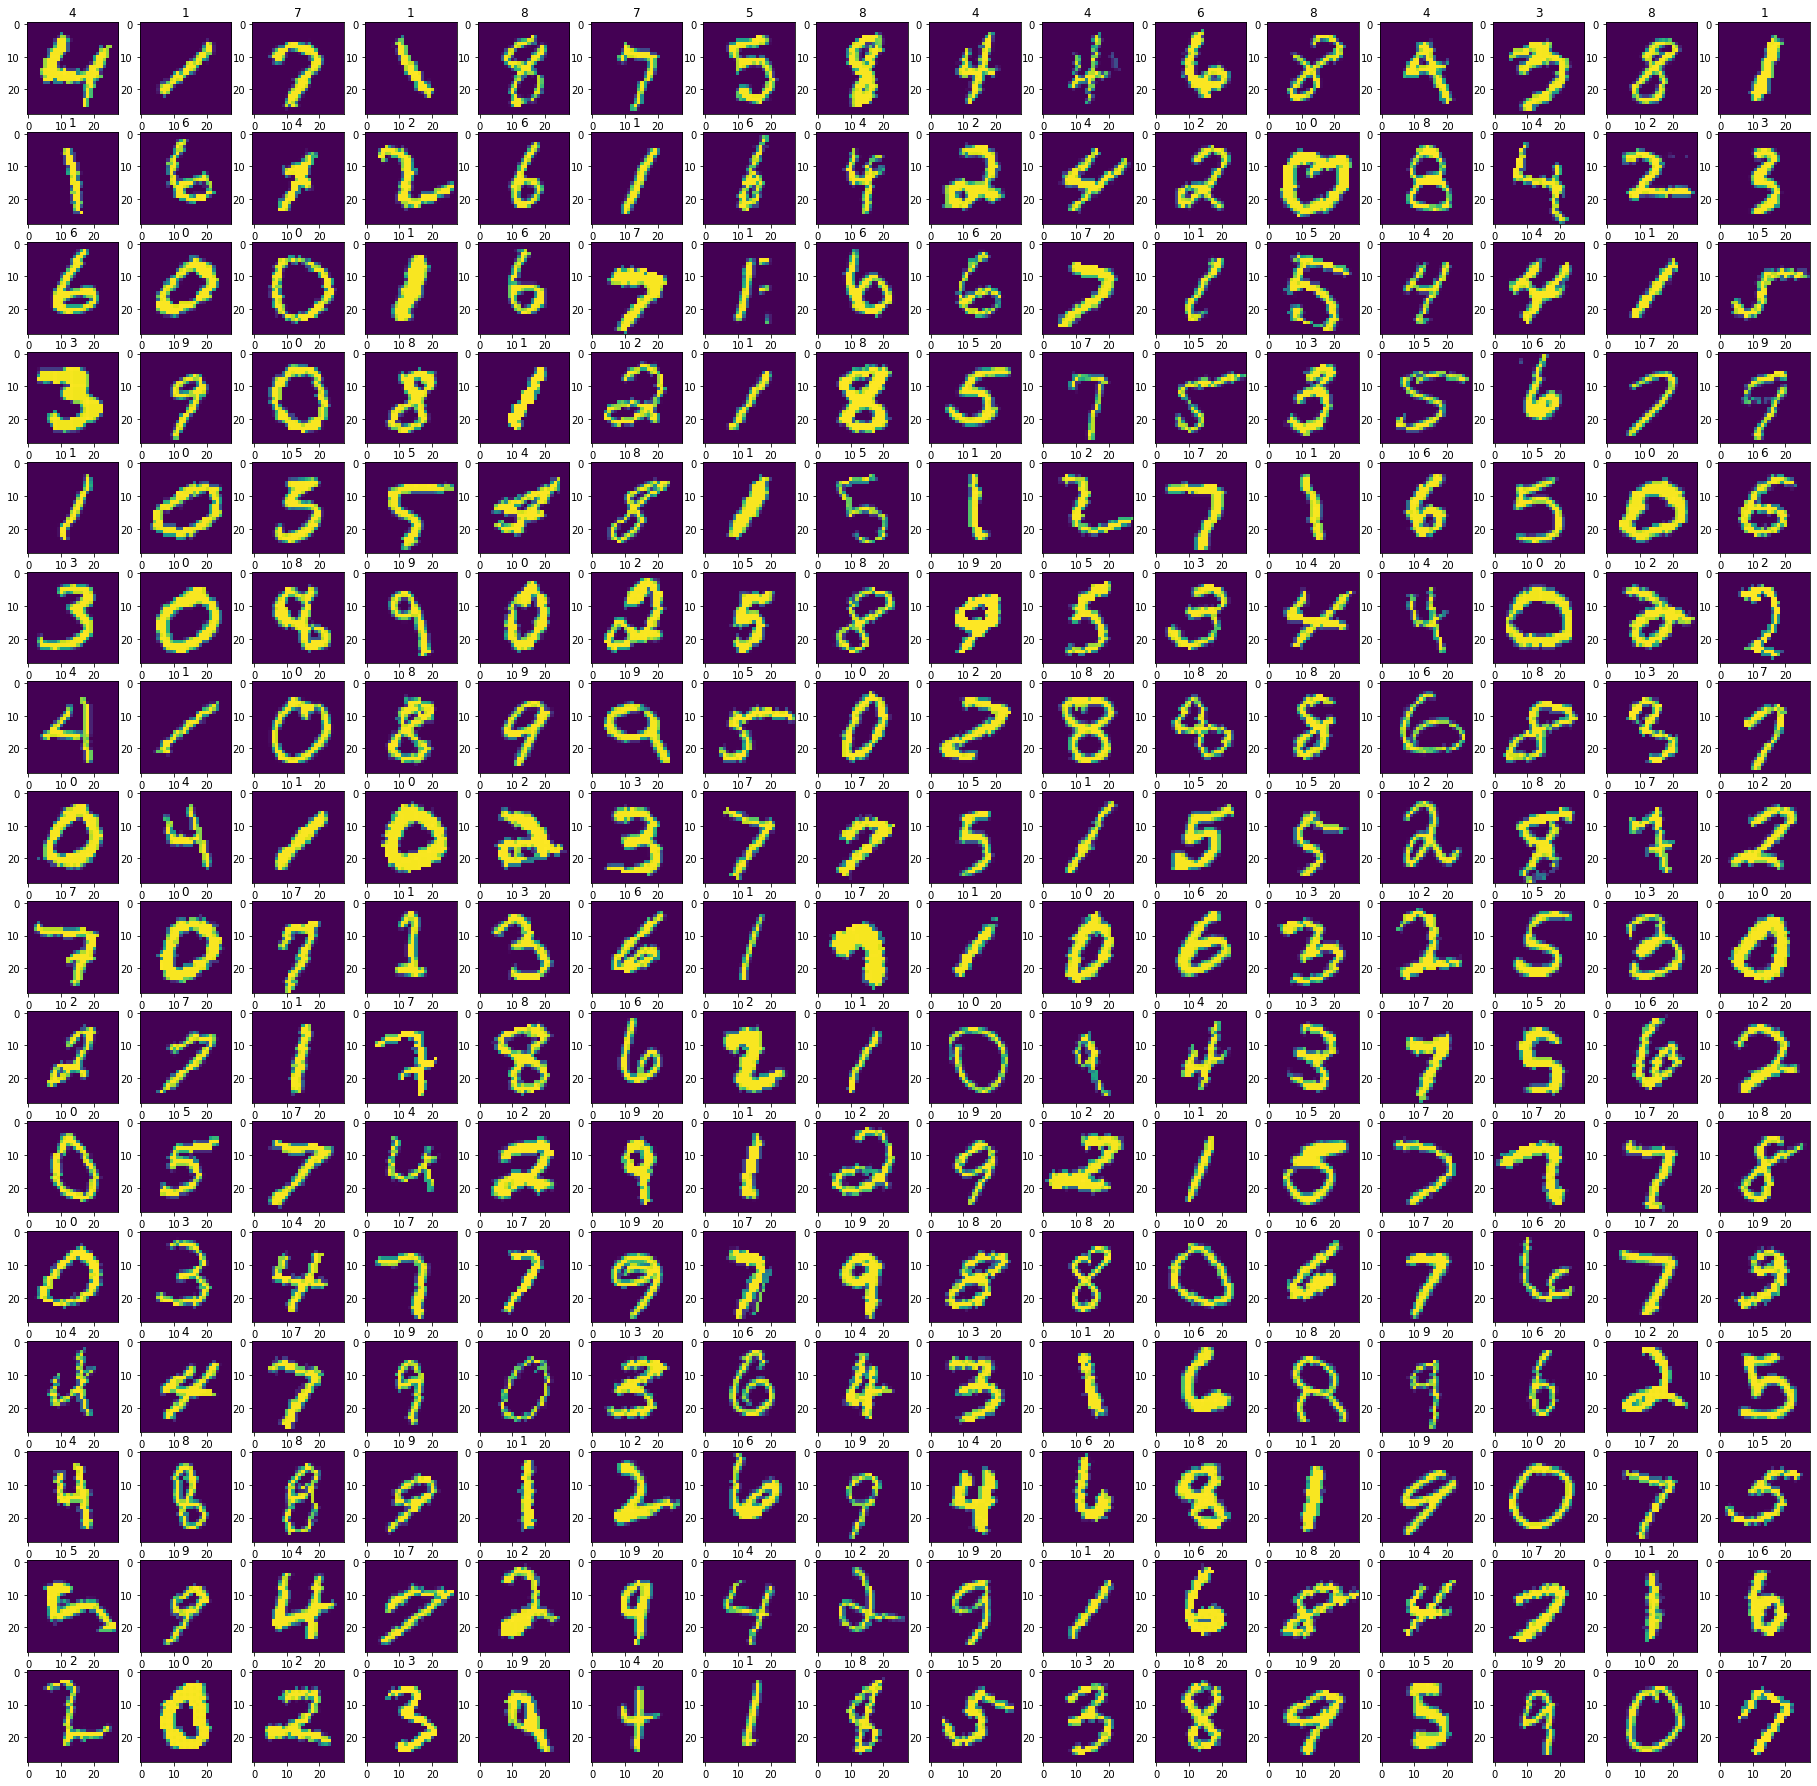

In [ ]:
indices = np.random.randint(0, len(train_dataset), size=256)

fig, axes = plt.subplots(nrows=16, ncols=16, figsize=(32, 32))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        sample_index = indices[i*16+j]
        sample, label = train_dataset[sample_index]
        ax.imshow(sample.cpu().numpy().transpose(1, 2, 0).squeeze())
        ax.set_title(label)

In [ ]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       data_loader: torch.utils.data.DataLoader):
    
    model.train()
    loss = 0

    for data in data_loader:
        x, y = data
        x = x.view(-1, 784)
        x = x.to(device)
        y = y.to(device)
        model.zero_grad()
        hyp = model(x)
        loss = loss_function(hyp, y)
        loss += loss
        optimizer.step()

    
    return loss / len(data_loader.dataset)

        

In [ ]:

def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    model.eval()
    loss = 0
    accuracy = 0

    for data in data_loader:
        x, y = data
        x = x.view(-1, 784)
        x = x.to(device)
        y = y.to(device)
        hyp = model(x)
        loss = loss_function(hyp, y)
        loss += loss
        y_pred = hyp.argmax(dim = 1, keepdim = True).to(device)
        accuracy += y_pred.eq(y.view_as(y_pred)).sum()

    loss = loss / len(data_loader.dataset)
    accuracy = 100.0 * accuracy / len(data_loader.dataset)
    
    return {'loss' : loss, 'accuracy' : accuracy}


In [ ]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 1000,
                early_stopping_patience = 20):
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    best_val_loss = None
    best_epoch = None
    
    for epoch in range(max_epochs):
        
        print(f'Epoch {epoch}')
        train_single_epoch(model, optimizer, loss_function, train_loader)
        val_metrics = validate_single_epoch(model, loss_function, val_loader)
        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step(val_metrics['loss'])
        
        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
            torch.save(model, './best_model.pth')
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            return

In [ ]:
train_model(model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr = 0.01)

Epoch 0


RuntimeError: ignored

True